# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [3]:
import os
import gc
import warnings
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
DATA_DIR = Path(".")
TRACKS_PATH = DATA_DIR / "tracks.parquet"
CATALOG_PATH = DATA_DIR / "catalog_names.parquet"
INTERACTIONS_PATH = DATA_DIR / "interactions.parquet"

tracks = pd.read_parquet(TRACKS_PATH)
catalog_names = pd.read_parquet(CATALOG_PATH)
interactions = pd.read_parquet(INTERACTIONS_PATH)

print(tracks.shape, catalog_names.shape, interactions.shape)

(1000000, 4) (1812471, 3) (222629898, 4)


In [5]:
tracks.head(3), catalog_names.head(3), interactions.head(3)

(   track_id              albums artists    genres
 0        26        [3, 2490753]    [16]  [11, 21]
 1        38        [3, 2490753]    [16]  [11, 21]
 2       135  [12, 214, 2490809]    [84]      [11],
    id   type               name
 0   3  album    Taller Children
 1  12  album  Wild Young Hearts
 2  13  album      Lonesome Crow,
    user_id  track_id  track_seq started_at
 0        0     99262          1 2022-07-17
 1        0    589498          2 2022-07-19
 2        0    590262          3 2022-07-21)

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [6]:
print("tracks.dtypes", end="\n")
display(tracks.dtypes)

print("catalog_names.dtypes", end="\n")
display(catalog_names.dtypes)

print(interactions.dtypes)
display(interactions.dtypes)

tracks.dtypes


track_id     int64
albums      object
artists     object
genres      object
dtype: object

catalog_names.dtypes


id       int64
type    object
name    object
dtype: object

user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object


user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [7]:
for col in ["track_id"]:
    tracks[col] = tracks[col].astype("int64", errors="ignore")
    
catalog_names["id"] = catalog_names["id"].astype("int", errors="ignore")
interactions["user_id"] = interactions["user_id"].astype("int64", errors="ignore")
interactions["track_id"] = interactions["track_id"].astype("int64", errors="ignore")
interactions["track_seq"] = interactions["track_seq"].astype("int32", errors="ignore")

interactions["started_at"] = pd.to_datetime(interactions["started_at"], errors="coerce")

print("Пустых дат started_at:", interactions["started_at"].isna().sum())

# Справочники по типам
catalog_type_map = {
    "artist": set(catalog_names.loc[catalog_names["type"] == "artist", "id"].unique()),
    "album": set(catalog_names.loc[catalog_names["type"] == "album", "id"].unique()),
    "genre": set(catalog_names.loc[catalog_names["type"] == "genre", "id"].unique())
}

def count_unknown_ids(series_with_lists, known_ids_set):
    total = 0
    unknown = 0
    for values in series_with_lists:
        if values is None:
            continue
        for v in values:
            total += 1
            if v not in known_ids_set:
                unknown += 1
    return total, unknown

artists_total, artists_unknown = count_unknown_ids(tracks["artists"], catalog_type_map["artist"])
albums_total, albums_unknown = count_unknown_ids(tracks["albums"], catalog_type_map["album"])
genres_total, genres_unknown = count_unknown_ids(tracks["genres"], catalog_type_map["genre"])

print(f"Неизвестные артисты: {artists_unknown}/{artists_total}")
print(f"Неизвестные альбомы: {albums_unknown}/{albums_total}")
print(f"Неизвестные жанры: {genres_unknown}/{genres_total}")

# Мягкая очистка: удаляем неизвестные id из списокв

def filter_known(values, known_ids_set):
    if values is None:
        return []
    return [v for v in values if v in known_ids_set]

tracks["artists"] = tracks["artists"].apply(lambda x: filter_known(x, catalog_type_map["artist"]))
tracks["albums"] = tracks["albums"].apply(lambda x: filter_known(x, catalog_type_map["album"]))
tracks["genres"] = tracks["genres"].apply(lambda x: filter_known(x, catalog_type_map["genre"]))

# Дополнительно: взаимодействия только с известными track_id
known_track_ids = set(tracks["track_id"].unique())
interactions = interactions[interactions["track_id"].isin(known_track_ids)].copy()

print("Треки:", tracks.shape)
print("Взаимодействия", interactions.shape)

Пустых дат started_at: 0
Неизвестные артисты: 0/1264212
Неизвестные альбомы: 0/3128808
Неизвестные жанры: 48369/1652658
Треки: (1000000, 4)
Взаимодействия (222629898, 4)


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [8]:
# Типы id привведены к числовым
# started_at приведен к datetime
# Неизвестные artists/albums/genres удалены из списков
# interactions отфильтрованы по валидным track_id

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

count    1.373221e+06
mean     1.621224e+02
std      3.512846e+02
min      1.000000e+00
50%      5.500000e+01
75%      1.540000e+02
90%      3.890000e+02
95%      6.500000e+02
99%      1.576000e+03
max      1.663700e+04
Name: n_plays, dtype: float64

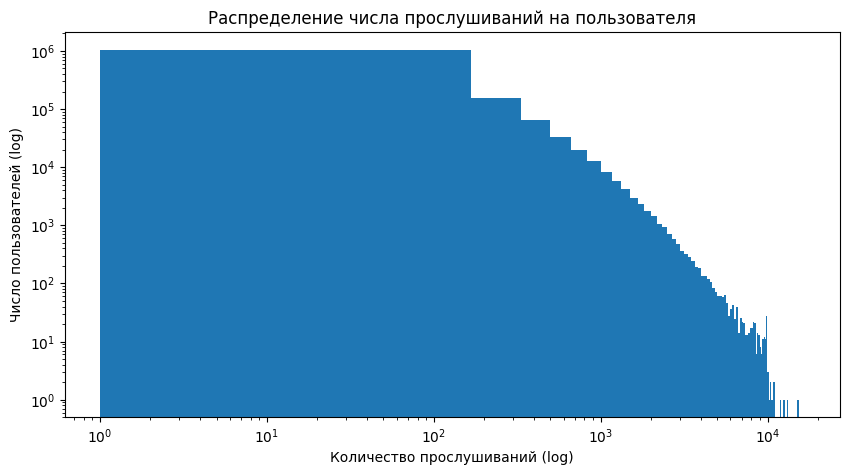

In [9]:
user_track_counts = interactions.groupby("user_id")["track_id"].count().rename("n_plays")
display(user_track_counts.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

vals = user_track_counts[user_track_counts > 0].values

plt.figure(figsize=(10,5))
plt.hist(vals, bins=100, log=True)
plt.xscale("log")
plt.title("Распределение числа прослушиваний на пользователя")
plt.xlabel("Количество прослушиваний (log)")
plt.ylabel("Число пользователей (log)")
plt.show()

Наиболее популярные треки

In [10]:
top_tracks = (
    interactions.groupby("track_id", as_index=False)
    .size()
    .rename(columns={"size": "play_count"})
    .sort_values("play_count", ascending=False)
)

display(top_tracks.head(20))

,track_id,play_count
9098,53404,111062
483876,33311009,106921
26665,178529,101924
512157,35505245,99490
829320,65851540,86670
368072,24692821,86246
475289,32947997,85886
696106,51241318,85244
90461,795836,85042
647237,45499814,84748


Наиболее популярные жанры

In [11]:
track_pop = top_tracks.set_index("track_id")["play_count"]

genres_exp = tracks[["track_id", "genres"]].explode("genres").rename(columns={"genres": "genre_id"})
genres_exp = genres_exp.dropna(subset=["genre_id"])

genre_pop = (
    genres_exp.merge(track_pop, left_on="track_id", right_index=True, how="left")
    .fillna({"play_count": 0})
    .groupby("genre_id", as_index=False)["play_count"]
    .sum()
    .sort_values("play_count", ascending=False)
)

genre_names = catalog_names.loc[catalog_names["type"] == "genre", ["id", "name"]].rename(columns={"id": "genre_id"})
genre_pop_named = genre_pop.merge(genre_names, on="genre_id", how="left")

display(genre_pop_named.head(20))

,genre_id,play_count,name
0,11,55578312,pop
1,75,37799821,rap
2,102,31092013,allrock
3,20,26626241,ruspop
4,3,25303695,rusrap
5,68,20120981,electronics
6,16,16291557,dance
7,2,13166147,rusrock
8,14,12772644,rock
9,47,12437375,metal


Треки, которые никто не прослушал

In [12]:
played_track_ids = set(interactions["track_id"].unique())
all_track_ids = set(tracks["track_id"].unique())

unplayed_track_ids = all_track_ids - played_track_ids
n_unplayed = len(unplayed_track_ids)

print(f"Треков, которые никто не слушал: {n_unplayed}")

unplayed_tracks = tracks[tracks["track_id"].isin(unplayed_track_ids)].copy()
display(unplayed_tracks.head(10))

Треков, которые никто не слушал: 0


,track_id,albums,artists,genres


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [13]:
items = tracks.copy()

events = interactions[["user_id", "track_id", "track_seq", "started_at"]].copy()
events = events.sort_values(["user_id", "started_at", "track_seq"]).reset_index(drop=True)

print("items:", items.shape)
print("events:", events.shape)

display(items.head(3))
display(events.head(3))

items: (1000000, 4)
events: (222629898, 4)


,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]


,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:

- `items.parquet` - все данные о музыкальных треках,

- `events.parquet` - все данные о взаимодействиях.

In [14]:
import os
from dotenv import load_dotenv

load_dotenv()

S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME")
S3_BUCKET = f"s3://{S3_BUCKET_NAME}"
assert S3_BUCKET_NAME, "Не задана S3_BUCKET_NAME"

storage_options = {
    "key": os.getenv("AWS_ACCESS_KEY_ID"),
    "secret": os.getenv("AWS_SECRET_ACCESS_KEY"),
    "client_kwargs": {"endpoint_url": "https://storage.yandexcloud.net"},
}

items.to_parquet("items.parquet", index=False)
events.to_parquet("events.parquet", index=False)

items_s3_path = f"{S3_BUCKET}/recsys/data/items.parquet"
events_s3_path = f"{S3_BUCKET}/recsys/data/events.parquet"

items.to_parquet(items_s3_path, index=False, storage_options=storage_options)
events.to_parquet(events_s3_path, index=False, storage_options=storage_options)

print(items_s3_path)
print(events_s3_path)

s3://s3-student-mle-20251026-ce7290c22e-freetrack/recsys/data/items.parquet
s3://s3-student-mle-20251026-ce7290c22e-freetrack/recsys/data/events.parquet


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [15]:
del user_track_counts, top_tracks, track_pop, genres_exp, genre_pop, genre_pop_named, unplayed_tracks
gc.collect()

25873

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [16]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

events["started_at"] = pd.to_datetime(events["started_at"], errors="coerce")

print(items.shape, events.shape)
display(items.head(2))
display(events.head(2))

(1000000, 4) (222629898, 4)


,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"


,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19


In [17]:
events = events.dropna(subset=["user_id", "track_id", "started_at"]).copy()
events["user_id"] = events["user_id"].astype("int64")
events["track_id"] = events["track_id"].astype("int64")
events = events.sort_values(["user_id", "started_at", "track_seq"]).reset_index(drop=True)

print(events.shape)

(222629898, 4)


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [18]:
CUT_OFF = pd.Timestamp("2022-12-16")

train_events = events[events["started_at"] < CUT_OFF].copy()
test_events = events[events["started_at"] >= CUT_OFF].copy()

# Тестируем только пользователей, которые есть в train
train_users = set(train_events["user_id"].unique())
test_events = test_events[test_events["user_id"].isin(train_users)].copy()

print("train:", train_events.shape)
print("test:", test_events.shape)
print("test users:", test_events["user_id"].nunique())

train: (208731252, 4)
test: (12796287, 4)
test users: 752870


In [ ]:
K = 20
eval_users = np.array(sorted(test_events["user_id"].unique()))
print("eval users:", len(eval_users))

eval users: 752870


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [20]:
pop = (
    train_events.groupby("track_id")
    .size()
    .sort_values(ascending=False)
    .rename("pop_score")
)

top_tracks = pop.head(K).index.to_numpy()
top_scores = pop.head(K).to_numpy()

top_popular = pd.DataFrame({
    "user_id": np.repeat(eval_users, K),
    "track_id": np.tile(top_tracks, len(eval_users)),
    "score": np.tile(top_scores, len(eval_users))
})
top_popular["rank"] = top_popular.groupby("user_id")["score"].rank(method="first", ascending=False).astype(int)

display(top_popular.head())
print(top_popular.shape)

,user_id,track_id,score,rank
0,3,53404,110026,1
1,3,33311009,101076,2
2,3,178529,100866,3
3,3,35505245,95523,4
4,3,24692821,84153,5


(15057400, 4)


In [21]:
top_popular.to_parquet("top_popular.parquet", index=False)

# Персональные

Рассчитаем персональные рекомендации.

In [22]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

user_ids = np.array(sorted(train_events["user_id"].unique()))
item_ids = np.array(sorted(train_events["track_id"].unique()))

user2idx = {u: i for i, u in enumerate(user_ids)}
item2idx = {t: i for i, t in enumerate(item_ids)}
idx2item = {i: t for t, i in item2idx.items()}

rows = train_events["user_id"].map(user2idx).to_numpy()
cols = train_events["track_id"].map(item2idx).to_numpy()
vals = np.ones(len(train_events), dtype=np.float32)

user_item = csr_matrix((vals, (rows, cols)), shape=(len(user_ids), len(item_ids)))
item_user = user_item.T.tocsr()

als = AlternatingLeastSquares(
    factors=64,
    regularization=0.05,
    iterations=15,
    random_state=RANDOM_STATE
)

als.fit(user_item)

100%|██████████| 15/15 [28:50<00:00, 115.38s/it]


In [23]:
from tqdm.auto import tqdm

# Рекомендации только для eval_users, которые есть в train матрице
valid_eval_users = [u for u in eval_users if u in user2idx]

MAX_USERS = 1000
rng = np.random.default_rng(42)
if len(valid_eval_users) > MAX_USERS:
    users_batch = rng.choice(valid_eval_users, size=MAX_USERS, replace=False).tolist()
else:
    users_batch = valid_eval_users

personal_rows = []
n_items = len(item_ids)

for u in users_batch:
    uidx = user2idx[u]
    recs, scores = als.recommend(
        userid=uidx,
        user_items=user_item[uidx],
        N=K,
        filter_already_liked_items=True
    )
    for rnk, (raw_id, sc) in enumerate(zip(recs, scores), start=1):
        raw_id = int(raw_id)

        if 0 <= raw_id < n_items:
            tid = int(item_ids[raw_id])
        elif raw_id in item2idx:
            tid = raw_id
        else:
            continue
            
        personal_rows.append((u, tid, float(sc), rnk))
        
personal_als = pd.DataFrame(personal_rows, columns=["user_id", "track_id", "score", "rank"])
display(personal_als.head())
print(personal_als.shape)

,user_id,track_id,score,rank
0,1028656,39257277,0.069548,1
1,1028656,38572747,0.060514,2
2,1028656,43052381,0.057121,3
3,1028656,35505245,0.050489,4
4,1028656,34976783,0.048129,5


(20000, 4)


In [24]:
personal_als.to_parquet("personal_als.parquet", index=False)

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [25]:
N_BASE_ITEMS = 1000 # 50000
N_SIM = 20

base_track_ids = pop.head(N_BASE_ITEMS).index.to_list()
similar_rows = []

for tid in base_track_ids:
    if tid not in item2idx:
        continue
    iidx = item2idx[tid]
    sim_items, sim_scores = als.similar_items(iidx, N=N_SIM+1)
    rank=1
    for sidx, sscore in zip(sim_items, sim_scores):
        sim_tid = idx2item[int(sidx)]
        if sim_tid == tid:
            continue
        similar_rows.append((tid, sim_tid, float(sscore), rank))
        rank += 1
        if rank > N_SIM:
            break
similar = pd.DataFrame(similar_rows, columns=["track_id", "similar_track_id", "similarity", "rank"])

display(similar.head())
print(similar.shape)

,track_id,similar_track_id,similarity,rank
0,53404,6705392,0.856484,1
1,53404,36246,0.804507,2
2,53404,37384,0.802169,3
3,53404,96089,0.795739,4
4,53404,148345,0.788778,5


(20000, 4)


In [26]:
similar.to_parquet("similar.parquet", index=False)

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [27]:
last_user_tracks = (
    train_events.sort_values("started_at")
    .groupby("user_id")
    .tail(3)[["user_id", "track_id"]]
    .rename(columns={"track_id": "src_track_id"})
)

i2i_user = (
    last_user_tracks
    .merge(similar[["track_id", "similar_track_id", "similarity"]],
           left_on="src_track_id", right_on="track_id", how="inner")
    .groupby(["user_id", "similar_track_id"], as_index=False)["similarity"]
    .max()
    .rename(columns={"similar_track_id": "track_id", "similarity": "i2i_score"})
)

cand_pop = top_popular[["user_id", "track_id", "score"]].rename(columns={"score": "pop_rank_score"})
cand_als = personal_als[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"})

candidates = (
    cand_pop.merge(cand_als, on=["user_id", "track_id"], how="outer")
    .merge(i2i_user, on=["user_id", "track_id"], how="outer")
    .fillna(0.0)
)

pop_norm = (pop / pop.max()).rename("pop_norm").reset_index()
candidates = candidates.merge(pop_norm, on="track_id", how="left").fillna({"pop_norm": 0.0})

print(candidates.shape)
display(candidates.head())

(26325094, 6)


,user_id,track_id,pop_rank_score,als_score,i2i_score,pop_norm
0,3,53404,110026.0,0.0,0.0,1.000000
1,3,33311009,101076.0,0.0,0.0,0.918656
2,3,178529,100866.0,0.0,0.0,0.916747
3,3,35505245,95523.0,0.0,0.0,0.868186
4,3,24692821,84153.0,0.0,0.0,0.764846


In [28]:
test_gt = (
    test_events.groupby("user_id")["track_id"]
    .apply(set)
    .to_dict()
)

candidates["target"] = candidates.apply(
    lambda r: 1 if r["track_id"] in test_gt.get(r["user_id"], set()) else 0,
    axis=1
)

print(candidates["target"].mean())
display(candidates.head())

0.009026520475102577


,user_id,track_id,pop_rank_score,als_score,i2i_score,pop_norm,target
0,3,53404,110026.0,0.0,0.0,1.000000,0
1,3,33311009,101076.0,0.0,0.0,0.918656,0
2,3,178529,100866.0,0.0,0.0,0.916747,0
3,3,35505245,95523.0,0.0,0.0,0.868186,0
4,3,24692821,84153.0,0.0,0.0,0.764846,0


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [29]:
from catboost import CatBoostClassifier

feature_cols = ["als_score", "pop_rank_score", "i2i_score", "pop_norm"]

rng = np.random.default_rng(42)
users_all = candidates["user_id"].unique()
rng.shuffle(users_all)

split = int(len(users_all) * 0.8)
rank_train_users = set(users_all[:split])
rank_test_users = set(users_all[split:])

rank_train = candidates[candidates["user_id"].isin(rank_train_users)].copy()
rank_test = candidates[candidates["user_id"].isin(rank_test_users)].copy()

clf = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=False,
    random_seed=42
)
clf.fit(rank_train[feature_cols], rank_train["target"])

rank_test["rank_score"] = clf.predict_proba(rank_test[feature_cols])[:, 1]

In [30]:
final_recs = (
    rank_test.sort_values(["user_id", "rank_score"], ascending=[True, False])
    .groupby("user_id")
    .head(K)
    .copy()
)
final_recs["rank"] = final_recs.groupby("user_id")["rank_score"].rank(method="first", ascending=False).astype(int)
final_recs = final_recs[["user_id", "track_id", "rank_score", "rank"]]

print(final_recs.shape)
display(final_recs.head())

final_recs.to_parquet("recommendations.parquet", index=False)

(3673680, 4)


,user_id,track_id,rank_score,rank
94,9,65851540,0.011577,1
96,9,60292250,0.011070,2
99,9,51516485,0.009057,3
90,9,51241318,0.006302,4
89,9,45499814,0.005572,5


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [31]:
def to_topk_dict(df, user_col="user_id", item_col="track_id", k=20):
    return (
        df.sort_values([user_col, "rank"])
        .groupby(user_col)[item_col]
        .apply(lambda x: list(x.head(k)))
        .to_dict()
    )
    
def precision_recall_at_k(recs_dict, gt_dict, k=20):
    users = [u for u in recs_dict.keys() if u in gt_dict and len(gt_dict[u]) > 0]
    if not users:
        return 0.0, 0.0
    precisions, recalls = [], []
    for u in users:
        recs = recs_dict[u][:k]
        gt = gt_dict[u]
        hit = len(set(recs) & set(gt))
        precisions.append(hit / k)
        recalls.append(hit / len(gt))
    return float(np.mean(precisions)), float(np.mean(recalls))

def coverage_at_k(recs_dict, train_items_set, k=20):
    rec_items = set()
    for _, recs in recs_dict.items():
        rec_items.update(recs[:k])
    return len(rec_items) / max(1, len(train_items_set))

def novelty_at_k(recs_dict, pop_prob, k=20):
    vals = []
    for _, recs in recs_dict.items():
        for t in recs[:k]:
            p = pop_prob.get(t, 1e-12)
            vals.append(-np.log2(max(p, 1e-12)))
    return float(np.mean(vals)) if vals else 0.0
    

In [32]:
gt_test = test_events.groupby("user_id")["track_id"].apply(set).to_dict()
train_items_set = set(train_events["track_id"].unique())
pop_prob = (pop / pop.sum()).to_dict()

top_popular_eval = top_popular[top_popular["user_id"].isin(rank_test_users)].copy()
top_popular_eval["rank"] = top_popular_eval.groupby("user_id")["score"].rank(method="first", ascending=False).astype(int)
top_dict = to_topk_dict(top_popular_eval, k=K)

pers_eval = personal_als[personal_als["user_id"].isin(rank_test_users)].copy()
pers_eval["rank"] = pers_eval.groupby("user_id")["score"].rank(method="first", ascending=False).astype(int)
pers_dict = to_topk_dict(pers_eval, k=K)

final_dict = to_topk_dict(final_recs.rename(columns={"rank_score": "score"}), k=K)

for name, recs_d in [("top_popular", top_dict), ("personal_als", pers_dict), ("final", final_dict)]:
    p, r = precision_recall_at_k(recs_d, gt_test, k=K)
    c = coverage_at_k(recs_d, train_items_set, k=K)
    n = novelty_at_k(recs_d, pop_prob, k=K)
    print(f"{name}: precision@{K}={p:.4f}, recall@{K}={r:.4f}, coverage@{K}={c:.4f}, novelty@{K}={n:.4f}")

top_popular: precision@20=0.0043, recall@20=0.0074, coverage@20=0.0000, novelty@20=11.3201
personal_als: precision@20=0.0095, recall@20=0.0259, coverage@20=0.0012, novelty@20=12.6503
final: precision@20=0.0124, recall@20=0.0339, coverage@20=0.0072, novelty@20=12.3593


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

### Этап 1. Первичная подготовка данных
- Загружены данные из файлов `tracks.parquet`, `catalog_names.parquet`, `interactions.parquet`.

- Типы идентификаторов приведены к числовым, поле `started_at` преобразовано в `datetime`.

- Выполнена проверка на неизвестные сущности: по артистам и альбомам проблем не обнаружено, по жанрам выявлены неизвестные id.

- Неизвестные жанры удалены из списков `genres`, взаимодействия оставлены только для валидных `track_id`.

### Этап 2. EDA и подготовка данных
- Выполнен анализ распределения числа прослушиваний на пользователя.

- Рассчитаны наиболее популярные треки и жанры.

- Определены треки, которые никто не прослушал.

- Подготовлены и сохранены датасеты:

  - `items.parquet` - данные о треках;

  - `events.parquet` - данные о взаимодействиях.
  
- Файлы выгружены в S3 по пути `recsys/data/`.

### Этап 3. Офлайн-рекомендации
- Данные разделены по дате: train - до **16 декабря 2022 года** (не включительно), test - начиная с **16 декабря 2022 года**.

- Построены рекомендации трех типов:

  - `top_popular.parquet`,

  - `personal_als.parquet`,

  - `similar.parquet`.

- Построена ранжирующая модель на признаках `als_score`, `pop_rank_score`, `i2i_score` (дополнительно `pop_norm`).

- Получены итоговые ранжированные рекомендации `recommendations.parquet`.

### Метрики качества
- **Top Popular**: precision@20 = `0.0043`, recall@20 = `0.0074`, coverage@20 = `0.0000`, novelty@20 = `11.3201`

- **Personal ALS**: precision@20 = `0.0095`, recall@20 = `0.0259`, coverage@20 = `0.0012`, novelty@20 = `12.6503`

- **Final (ranked)**: precision@20 = `0.0124`, recall@20 = `0.0339`, coverage@20 = `0.0072`, novelty@20 = `12.3593`

### Ограничения расчёта
- Для ускорения экспериментов в рамках доступных вычислительных ресурсов расчёт персональных рекомендаций ALS выполнялся для подвыборки пользователей: `MAX_USERS = 1000`.

- Для блока похожих треков (i2i) использовалась ограниченная база популярных треков: `N_BASE_ITEMS = 1000` (вместо полного/большего набора, например 50000).

- Эти ограничения уменьшили время выполнения пайплайна, но могли снизить итоговые значения метрик (в первую очередь coverage и, частично, recall/precision).

- Цель работы - построение рабочего прототипа рекомендательной системы; ограничение объёма расчётов принято как инженерный компромисс.

### Итог
- Построен рабочий прототип рекомендательной системы: выполнены подготовка данных, расчет нескольких типов рекомендаций, ранжирование и оценка качества.

- По итоговым метрикам final превосходит top_popular и personal_als: `precision@20 = 0.0124`, `recall@20 = 0.0339`, `coverage@20 = 0.0072`.